## Exercise 1: Implementation of multi-layer NN

#### 1. Initialization

In [77]:
import numpy as np
import math
import time

In [11]:
np.random.seed(666)

In [12]:
class Model:
    def __init__(self, W, B):
        self.W = W
        self.B = B

In [61]:
def initialize(K, D, D_i, D_o):
    W = [None] * (K+1)
    B = [None] * (K+1)

    #initialize first layer
    W[0] = np.random.normal(0, np.sqrt(2 / D_i), size=(D, D_i))
    B[0] = np.random.normal(size =(D,1))

    #hidden layers
    for layer in range(1,K):
        W[layer] = np.random.normal(0, np.sqrt(2 / D), size=(D, D)) #He initialization
        B[layer] = np.zeros((D,1))

    #last layer
    W[-1] = np.random.normal(0, np.sqrt(2 / D), size=(D_o, D))
    B[-1]= np.random.normal(size =(D_o,1))


    return W,B



In [ ]:
# W, B = initialize(K, D, D_i, D_o)
# model = Model(W, B)

#### 2. Activation functions

In [15]:
def relu(x):
    activation = x.clip(0.0)
    return activation

def relu_der(x):
    dx = np.array(x)
    dx[dx>0] = 1
    dx[dx<=0] = 0
    return dx

def sigmoid(x):
    activation = 1.0 / (1.0 + np.exp(-x))
    return activation

def sigmoid_der(x):
    sigma = 1.0 / (1.0 + np.exp(-x))
    dx = sigma * (1.0 - sigma)
    return dx

#### 3. Forward pass

In [48]:
def forward_pass(net_input, W, B):
 
    K = len(W) -1 # number of layers

    F = [None] * (K+1) # pre-activations at each layer
    H = [None] * (K+1) # activations

    H[0] = net_input
    #print(f"Assigning H[0] as net_input: {H[0].shape}")


    # print(f"F init len: {len(F)}")
    # print(f"H init len: {len(H)}")
    # print(f"Input shape: {net_input.shape}")
    # Run through the layers, calculating F[0...K-1] and H[1...K]
    for layer in range(K):

        # print(f"Processing layer {layer}/{K}")
        # print(f"W[{layer}] shape = {W[layer].shape}")
        # print(f"B[{layer}] shape = {B[layer].shape}")


        F[layer] = B[layer] + W[layer] @ H[layer] 
        #print(f"F[{layer}] shape = {F[layer].shape}")
        #print(F[layer])


        H[layer+1] = relu(F[layer])
        #print(f"H[{layer+1}] shape = {H[layer+1].shape}")
        #print(H[layer+1])


    
    F[K] = B[K] + W[K] @ H[K] 

    net_output = F[K]
    #print(f"net_output shape = {net_output.shape}")


    return net_output, F, H

#### 4. Cost

In [49]:
def softmax(x):

    shifted_x = x - np.max(x, axis=0, keepdims=True) # For numerical stability when f >> 0,preventing overflow of exp(x)
    
    exp_x = np.exp(shifted_x)
    probs = exp_x / np.sum(exp_x, axis=0, keepdims=True)
    
    return probs


def cross_entropy_cost(net_output, y):
    I = y.shape[1]  # Number of data points if data points as columns
    probs = softmax(net_output)
    #print(f"probs shape: {probs.shape}")
    #print(f"vibe check: {np.sum(probs, axis=0)[:5]}")
    #print(f"y shape: {y.shape}")
    out = np.sum(-1 * y * np.log(probs))/I
    #print(f"cross_entropy_cost shape: {out.shape}")

    return out

def d_cost_d_output(net_output, y):
    I = y.shape[1] # Number of data points if data points as columns
    probs = softmax(net_output)
    #print(f"probs shape: {probs.shape}")
    #print(f"y shape: {y.shape}")
    out = (probs - y)/I
    #out = 2*np.sum((probs - y),axis=0)/I
    #print(f"d_cost_d_output shape: {out.shape}")
    return out

#### 5. Backprop

In [57]:
def backward_pass(W, B, F, H, y):

    K = len(W)-1
    # We'll store the derivatives dl_dweights and dl_dbiases in lists as well
    dl_dW = [None] * (K+1)
    dl_dB = [None] * (K+1)
    # And we'll store the derivatives of the cost wrt the activation and preactivations in lists
    dl_df = [None] * (K+1)
    dl_dh = [None] * (K+1)
    # Again for convenience we'll stick with the convention that H[0] is the net input and F[k] in the net output

    #print("Backprop: ------------------------------")
    # Compute derivatives of the cost wrt the network output
    dl_df[K] = np.array(d_cost_d_output(F[K],y.T))
    #print(f"dl_df[{K}] shape: {dl_df[K].shape}")

    layer_range = np.flip(range(K+1))

    for layer in layer_range:
        # Calculate the derivatives of the cost wrt the biases at layer from dl_df[layer].
        dl_dB[layer] = np.sum(dl_df[layer], axis=1, keepdims=True) 
        #print(f"dl_dB[{layer}] shape: {dl_dB[layer].shape}")


        # Calculate the derivatives of the cost wrt the weights at layer from dl_df[layer] and H[layer] 
        dl_dW[layer] = dl_df[layer] @ H[layer].T
        #print(f"dl_dW[{layer}] shape: {dl_dW[layer].shape}")


        # Calculate the derivatives of cost wrt activations from weight and derivatives of next preactivations 
        dl_dh[layer] =  W[layer].T @ dl_df[layer]
        #print(f"dl_dh[{layer}] shape: {dl_dh[layer].shape}")


        if layer > 0:
            # Calculate derivatives of the cost wrt pre-activation f 
            dl_df[layer-1] = relu_der(F[layer-1]) * dl_dh[layer] 
            #print(f"dl_df[{layer-1}] shape: {dl_df[layer-1].shape}")

            
    return dl_dW, dl_dB

#### 6. Step & parameter update

In [51]:
def update_parameters(W, B, dW, dB, lr):
    W_new = W - lr*dW
    B_new = B - lr*dB
    return W_new, B_new

#### 7. Predict

In [52]:
def predict(model, x, y):

    res_logits, F, H = forward_pass(x.T, model.W, model.B)

    res = softmax(res_logits)

    # binarize
    res_binary = np.where(res == np.max(res), 1,0)

    acc = accuracy(y.T, res_binary)

    cost = cross_entropy_cost(res_logits, y.T)
    
    return res, acc, cost


def accuracy(y_true, y_pred):
    y_true_ind = np.argmax(y_true, axis=0)
    y_pred_ind = np.argmax(y_pred, axis=0)
    acc = np.mean(y_true_ind == y_pred_ind)

    return acc
    

In [53]:
def performance(y, preds):
    return 0

#### 8. Mini-batch

In [54]:
def random_mini_batches(x,y, size):
    assert len(x) == len(y)
    p = np.random.permutation(len(x))
    # x[p], y[p] are permuted arrays

    num_batches = math.ceil(len(x)/size)


    x_batched = np.array_split(x[p], num_batches)
    y_batched = np.array_split(y[p], num_batches)

    return x_batched, y_batched



#### 9. Model Training

In [14]:
# import imageio

# test = imageio.imread("MNIST/Train/4/0001.png")
# test = np.array(test)


In [7]:
from utils import load_mnist
X_train, Y_train, X_test, Y_test = load_mnist()

In [81]:
def train_model(X_train, Y_train, X_test, Y_test, model, epochs, lr, batch_size):

    start = time.time()

    train_accuracies = np.zeros(epochs)
    test_accuracies = np.zeros(epochs)
    train_costs = np.zeros(epochs)
    test_costs = np.zeros(epochs)

    for epoch in range(epochs):

        X_batches, Y_batches = random_mini_batches(X_train, Y_train, batch_size)

        for X_batch, Y_batch in zip(X_batches, Y_batches):
            # Forward pass
            net_out, F, H = forward_pass(X_batch.T, model.W, model.B)

            # Backward pass
            dl_dW, dl_dB = backward_pass(model.W, model.B, F, H, Y_batch)

            # Update parameters layer by layer
            for k in range(len(model.W)):
                model.W[k], model.B[k] = update_parameters(
                    model.W[k], model.B[k],
                    dl_dW[k], dl_dB[k],
                    lr
                )

        # Evaluate after each epoch
        _, train_accuracies[epoch], train_costs[epoch] = predict(model, X_train, Y_train)
        _, test_accuracies[epoch], test_costs[epoch] = predict(model, X_test, Y_test)

        print(f"Epoch {epoch+1}/{epochs} "
              f"| Train acc: {train_accuracies[epoch]:.4f} "
              f"| Test acc: {test_accuracies[epoch]:.4f} "
              f"| Train cost: {train_costs[epoch]:.4f}"
              f"| Test cost: {test_costs[epoch]:.4f}")

    end = time.time()
    time_elapsed = end - start
    print(f"End of training. Time elapsed: {time_elapsed}")
    return model, train_accuracies, test_accuracies, train_costs, test_costs, time_elapsed


In [67]:
# Number of hidden layers
K = 5
# Number of neurons per layer
D = 100
# Input layer dimension
D_i = 784
# Output layer dimension
D_o = 10

W, B = initialize(K, D, D_i, D_o)
model1 = Model(W, B)

In [82]:
model1_trained, train_accuracies, test_accuracies, train_costs, test_costs, time_elapsed = train_model(X_train, Y_train, X_test, Y_test, model1, 10, 0.001, 32)

Epoch 1/10 | Train acc: 0.0987 | Test acc: 0.0980 | Train cost: 0.1520| Test cost: 0.1630
Epoch 2/10 | Train acc: 0.0987 | Test acc: 0.0980 | Train cost: 0.1481| Test cost: 0.1592
Epoch 3/10 | Train acc: 0.0987 | Test acc: 0.0980 | Train cost: 0.1442| Test cost: 0.1549
Epoch 4/10 | Train acc: 0.0987 | Test acc: 0.0980 | Train cost: 0.1423| Test cost: 0.1537
Epoch 5/10 | Train acc: 0.0987 | Test acc: 0.0981 | Train cost: 0.1367| Test cost: 0.1501
Epoch 6/10 | Train acc: 0.0987 | Test acc: 0.0981 | Train cost: 0.1335| Test cost: 0.1480
Epoch 7/10 | Train acc: 0.0987 | Test acc: 0.0981 | Train cost: 0.1314| Test cost: 0.1476
Epoch 8/10 | Train acc: 0.0987 | Test acc: 0.0980 | Train cost: 0.1252| Test cost: 0.1414
Epoch 9/10 | Train acc: 0.0987 | Test acc: 0.0981 | Train cost: 0.1244| Test cost: 0.1420
Epoch 10/10 | Train acc: 0.0987 | Test acc: 0.0980 | Train cost: 0.1209| Test cost: 0.1375
End of training. Time elapsed: 198.4080991744995


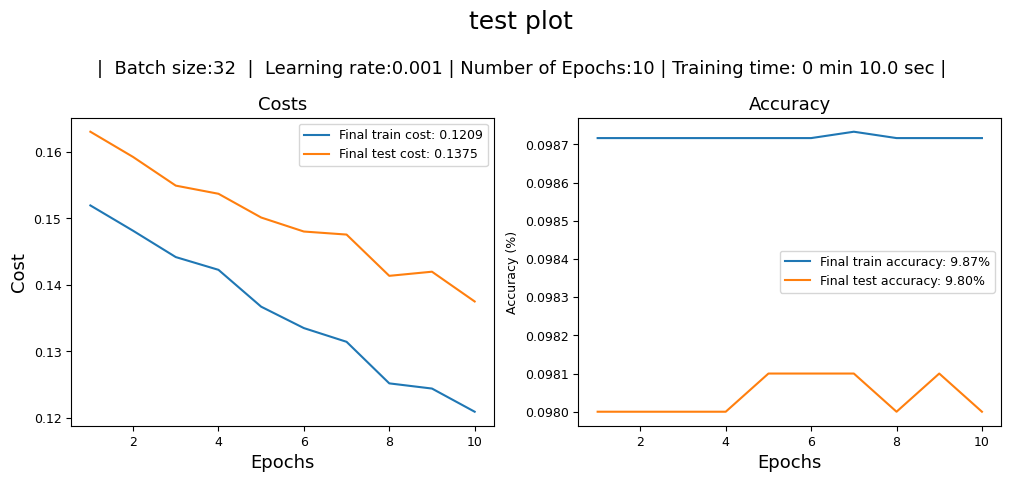

In [83]:
from utils import training_curve_plot
training_curve_plot("test plot", train_costs, test_costs, train_accuracies, test_accuracies, 32, 0.001, 10, 10)
